In [142]:
import torch as t
import torchmetrics
from DiagnosisAI.utils.metrics import calculate_type_errors, calc_metrics
from DiagnosisAI.models.resnet3d import generate_model
from medmnist import INFO
import medmnist
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from torch.utils import data
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


In [102]:
logs = pd.read_csv('../trainings/logs/classif_3d/resnet18/logs_29_07_21_08.csv')

<AxesSubplot:>

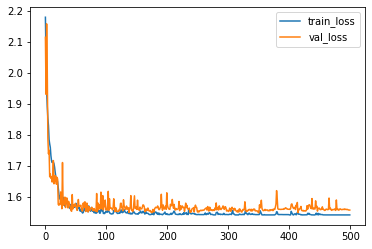

In [103]:
logs[['train_loss', 'val_loss']].plot()

<AxesSubplot:>

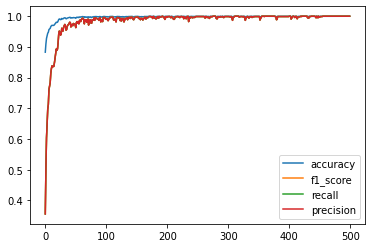

In [104]:
logs[['accuracy', 'f1_score', 'recall', 'precision']].plot()

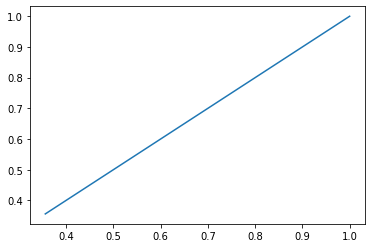

In [105]:
plt.plot(logs['recall'].values, logs['precision'].values)

In [106]:
batch_size = 1
data_flag = 'organmnist3d'
download = True
device = t.device('cpu')
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
test_dataset = DataClass(split='test',  download=download)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: /Users/michalnt/.medmnist/organmnist3d.npz


In [107]:
network = generate_model(model_depth=18, n_classes=11, n_input_channels=1)
network.fc

Linear(in_features=512, out_features=11, bias=True)

In [108]:
model_state_path = "../trainings/model_states/classif_3d/resnet18/model_state"
network.load_state_dict(t.load(model_state_path, map_location=device))

<All keys matched successfully>

In [109]:
from torchmetrics import Accuracy, Recall, F1Score, Precision

In [ ]:
network.eval()
global_tp = 0
global_fp = 0
global_tn = 0
global_fn = 0
accs = 0.0
recalls = 0.0
f1scores = 0.0
precisions = 0.0
for i, (inputs, labels) in enumerate(tqdm(test_loader), 0):
    with t.no_grad():        
        outputs = network(inputs.type(t.float32))
    outputs = nn.Softmax(dim=1)(outputs)
    labels = nn.functional.one_hot(labels, num_classes=11)
    labels = labels.squeeze()

    pred_classes = t.argmax(outputs, dim=1)
    target_classes = t.argmax(labels, dim=1)

    tp, fp, tn, fn = calculate_type_errors(pred_classes, target_classes, mode='classif_multiclass', num_classes=11)
    global_tp += tp.numpy()
    global_fp += fp.numpy()
    global_tn += tn.numpy()
    global_fn += fn.numpy()

    accs += Accuracy()(pred_classes, target_classes).item()
    recalls += Recall()(pred_classes, target_classes).item()
    precisions += Precision()(pred_classes, target_classes).item()
    f1scores += F1Score()(pred_classes, target_classes).item()

# calc metrics
recall, precision, acc, f1_score = calc_metrics(global_tp, global_fp, global_tn, global_fn)

# print(f"Recall: {recall}, Precision: {precision}, Acc: {acc}, F1_score: {f1_score}")
# print(f"Metrics acc: {accs / (i+1)}, Recalls: {recalls / (i+1)}, Prec: {precisions / (i+1)}, f1: {f1scores / (i+1)}")

In [110]:
results = pd.DataFrame({'Recall': recall.flatten(), "Accuracy": acc.flatten(), "F1_score": f1_score.flatten(), "Precision": precision.flatten()})

In [111]:
results

,Recall,Accuracy,F1_score,Precision
0,1.000000,1.000000,1.000000,1.000000
1,0.808824,0.950820,0.785714,0.763889
2,0.753623,0.944262,0.753623,0.753623
3,0.784615,0.957377,0.796875,0.809524
4,0.830769,0.962295,0.824427,0.818182
5,0.909091,0.981967,0.916031,0.923077
6,0.892857,0.995082,0.943396,1.000000
7,1.000000,0.998361,0.976744,0.954545
8,1.000000,1.000000,1.000000,1.000000
9,0.927536,0.980328,0.914286,0.901408


In [112]:
embedd_network = nn.Sequential(*list(network.children())[:-1])

In [114]:
embedd_network.eval()
labels_e = []
embeddings = []
for i, (inputs, labels) in enumerate(tqdm(test_loader), 0):
    with t.no_grad():
        outputs = embedd_network(inputs.type(t.float32))
        embeddings.append(outputs.squeeze().numpy())
        labels_e.append(labels.squeeze().item())

100%|██████████| 610/610 [00:25<00:00, 23.80it/s]


In [115]:
embeddings = np.array(embeddings)

In [138]:
neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean').fit(embeddings)

sprawdzanie najblizszych 5 sasiadow dla pierwszego wektora cech czyli labelu 10 (trzustki)

In [139]:
distances, indices = neighbors.kneighbors([embeddings[0]])

In [140]:
distances, indices

(array([[4.7683716e-07, 3.1431754e+00, 4.7513242e+00, 5.1761189e+00,
         5.3200040e+00, 5.9101386e+00, 5.9485803e+00, 5.9672623e+00,
         6.3393960e+00, 6.3917789e+00]], dtype=float32),
 array([[  0, 116, 114, 506, 596, 100, 351, 142, 250,  71]]))

Pierwszych 5 sasiadow ma label:

In [141]:
np.take(labels_e, indices.flatten())

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

Jak widać zgadza się

In [143]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(embeddings)

/Users/michalnt/miniconda3/envs/typical_deeplearning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/michalnt/miniconda3/envs/typical_deeplearning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 610 samples in 0.001s...
[t-SNE] Computed neighbors for 610 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 610 / 610
[t-SNE] Mean sigma: 4.536652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.336014
[t-SNE] KL divergence after 1000 iterations: 0.324277


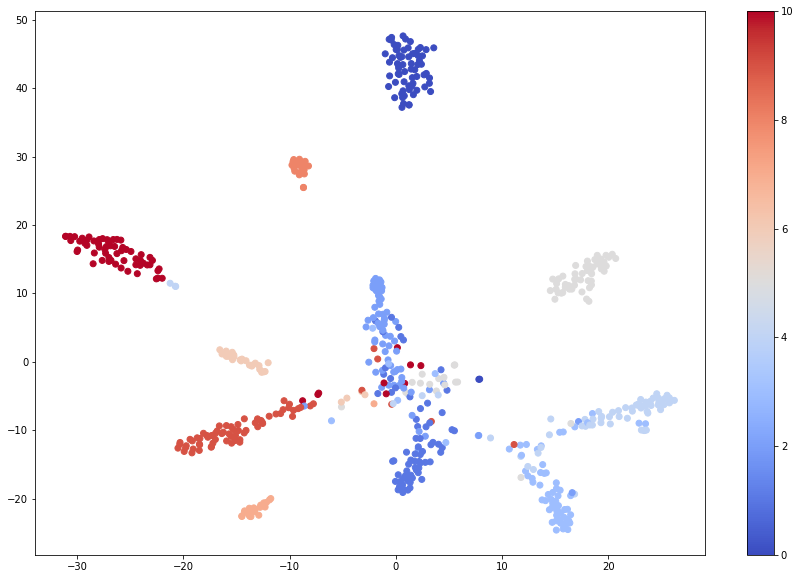

In [145]:
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=labels_e, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar()